In [1]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot as plt 
import array
from matplotlib import pyplot as plt

In [2]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10 ## number of clusters
PHI = [] ## to store design matrix
IsSynthetic = False
Width = 0

In [3]:
#Storing the expected target values from the file into array t
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    return t

def GenerateRawData(filePath, IsSynthetic): #Fetching the data from the file and storing it into dataMatrix   
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1) ## these columns have zero values, their covariance would be zero
    dataMatrix = np.transpose(dataMatrix)     
    #print ("Data Matrix Generated..")
    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80): ##selecting only 80% of total data for training and fetching its target vector values
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):##selecting only 80% of total data for training 
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): ##selecting another 10% of total data for validation and the for testing
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic,Width): ## it is used to create the co-variance matrix
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j] ##we only need the values of the diagonal elements of a covariance matrix
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(Width*.01*(10**Width),BigSigma)## Width is used for tuning the model, it increases the variance
       
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):  ##fomula for calculating basis function  
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80): ## it is used for craeting the design matrix
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetWeightsClosedForm(PHI, T, Lambda): ##It calculates weight using phi matrix, target vector and lambda
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T) ## final formula becomes W= (Lambda + ф*ф_Transpose)_inverse  *  (ф_Transpose * target)
    ##print ("Training Weights Generated..")
    return W

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):##creating the design matrix
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

def GetErms(VAL_TEST_OUT,ValDataAct):# finds the error root mean squae for  the given data, it compares the actual value with the expected value
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [4]:
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)

C:\Users\aroos\Anaconda3\envs\iris_2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 'U' mode is deprecated
  after removing the cwd from sys.path.
C:\Users\aroos\Anaconda3\envs\iris_2\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 'U' mode is deprecated
  del sys.path[0]


## Prepare Training Data

In [5]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(55699,)
(41, 55699)


## Prepare Validation Data

In [6]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Prepare Test Data

In [7]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(TestDataAct.shape)
print(TestData.shape)

(6961,)
(41, 6961)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

M =1
Lambda =0.1
E_rms Training   = 0.6427529035300575
E_rms Validation = 0.6282628133169708
E_rms Testing    = 0.7408882410461395
Accuracy Testing   = 70.23416175836805
M =1
Lambda =2.0
E_rms Training   = 0.6291726989697519
E_rms Validation = 0.6145247378828577
E_rms Testing    = 0.7245673889895873
Accuracy Testing   = 69.71699468467175
M =1
Lambda =30.0
E_rms Training   = 0.5739418763580454
E_rms Validation = 0.5626546708919288
E_rms Testing    = 0.6518339490640811
Accuracy Testing   = 70.23416175836805
M =1
Lambda =400.0
E_rms Training   = 0.5647041154115904
E_rms Validation = 0.5539445044177406
E_rms Testing    = 0.6400319301310835
Accuracy Testing   = 70.23416175836805
M =1
Lambda =5000.0
E_rms Training   = 0.5649843730740433
E_rms Validation = 0.553827046136877
E_rms Testing    = 0.6429119421989584
Accuracy Testing   = 70.23416175836805


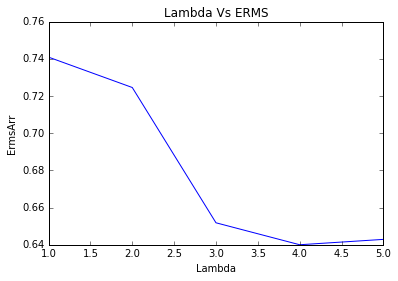

M =11
Lambda =0.1
E_rms Training   = 0.6427528984352141
E_rms Validation = 0.6282628125486431
E_rms Testing    = 0.7408882386822628
Accuracy Testing   = 70.23416175836805
M =11
Lambda =2.0
E_rms Training   = 0.6149166326086989
E_rms Validation = 0.6015941509841954
E_rms Testing    = 0.7095542618621802
Accuracy Testing   = 68.84068380979744
M =11
Lambda =30.0
E_rms Training   = 0.5521891466386234
E_rms Validation = 0.5424701890860169
E_rms Testing    = 0.628611221054567
Accuracy Testing   = 70.11923574199109
M =11
Lambda =400.0
E_rms Training   = 0.5599630818461021
E_rms Validation = 0.5488095825078251
E_rms Testing    = 0.6357550888641107
Accuracy Testing   = 70.23416175836805
M =11
Lambda =5000.0
E_rms Training   = 0.564400540511381
E_rms Validation = 0.5536664657038907
E_rms Testing    = 0.6397451836761452
Accuracy Testing   = 70.23416175836805


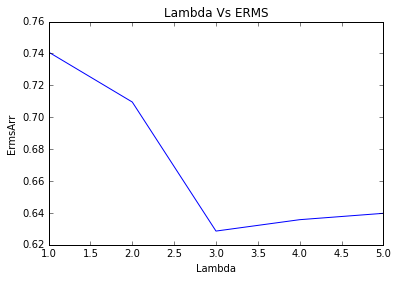

M =21
Lambda =0.1
E_rms Training   = 0.642752856308148
E_rms Validation = 0.6282627430125443
E_rms Testing    = 0.7408882023425261
Accuracy Testing   = 70.23416175836805
M =21
Lambda =2.0
E_rms Training   = 0.6066306247051635
E_rms Validation = 0.595192864176806
E_rms Testing    = 0.6972247151220713
Accuracy Testing   = 68.82631805775033
M =21
Lambda =30.0
E_rms Training   = 0.5494465037368979
E_rms Validation = 0.5404984784263781
E_rms Testing    = 0.6273179156700758
Accuracy Testing   = 69.6164344203419
M =21
Lambda =400.0
E_rms Training   = 0.55725110939963
E_rms Validation = 0.5459526128392471
E_rms Testing    = 0.6336409609502813
Accuracy Testing   = 70.23416175836805
M =21
Lambda =5000.0
E_rms Training   = 0.5643879979352604
E_rms Validation = 0.5536753551556489
E_rms Testing    = 0.6395961142963466
Accuracy Testing   = 70.23416175836805


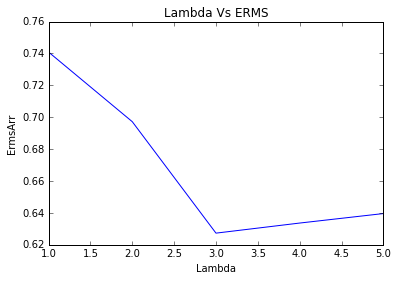

M =31
Lambda =0.1
E_rms Training   = 0.6427526456427277
E_rms Validation = 0.628262648148756
E_rms Testing    = 0.7408877073328477
Accuracy Testing   = 70.23416175836805
M =31
Lambda =2.0
E_rms Training   = 0.6045979058074382
E_rms Validation = 0.5930665114795357
E_rms Testing    = 0.6961726952065399
Accuracy Testing   = 68.76885504956185
M =31
Lambda =30.0
E_rms Training   = 0.5468893499553777
E_rms Validation = 0.539374114865649
E_rms Testing    = 0.6259465577763952
Accuracy Testing   = 69.58770291624766
M =31
Lambda =400.0
E_rms Training   = 0.5555316953032732
E_rms Validation = 0.5443296773299638
E_rms Testing    = 0.632132218388237
Accuracy Testing   = 70.23416175836805
M =31
Lambda =5000.0
E_rms Training   = 0.5643850807473036
E_rms Validation = 0.553682855936783
E_rms Testing    = 0.6395449437346774
Accuracy Testing   = 70.23416175836805


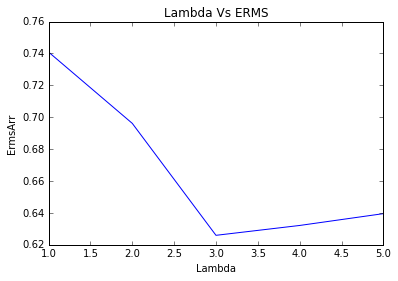

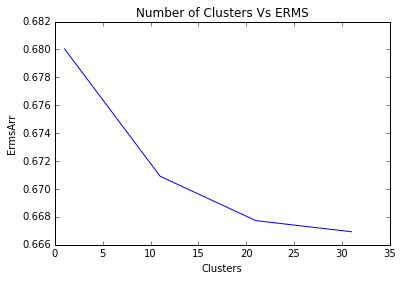

In [8]:
lamda = []
clusters = []
ErmsArr = []
AccuracyArr = []
clusters_erms=[]
for m in range(1,40,10):#changing number of clusters
 for lam in range(1,6,1):  #changing lambda values   
        kmeans = KMeans(n_clusters=m, random_state=0).fit(np.transpose(TrainingData))##using kmeans to form clusters
        ##print statements
        
        lamda.append(lam)
        
        Mu = kmeans.cluster_centers_

        BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic,lam)
        TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
        W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(lam*.01*(10**lam)))
        ##W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(200)) 
        TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
        VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

        TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
        VAL_TEST_OUT = GetValTest(VAL_PHI,W)
        TEST_OUT     = GetValTest(TEST_PHI,W)

        TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
        ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
        TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

        print ("M ="+str(int(m)))
        print ("Lambda ="+ str(float(lam*.01*(10**lam))))
        print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
        print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
        print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))
        print ("Accuracy Testing   = " + str(float(TestAccuracy.split(',')[0])))  

        ErmsArr.append(float(TestAccuracy.split(',')[1]))#finding ERMS for changing lambda values
        AccuracyArr.append(float(TestAccuracy.split(',')[0]))
 # E= np.array(ErmsArr)
 plt.plot(lamda, ErmsArr)
 # x axis values 
 plt.xlabel('Lambda') 
 # naming the y axis 
 plt.ylabel('ErmsArr') 
 plt.title('Lambda Vs ERMS') 
 plt.show()
    
 average_of_cluster=sum(ErmsArr) / float(len(ErmsArr))
 clusters_erms.append(average_of_cluster)
 clusters.append(m) 
 lamda.clear()
 ErmsArr.clear()

plt.plot(clusters, clusters_erms)
# x axis values 
plt.xlabel('Clusters') 
# naming the y axis 
plt.ylabel('ErmsArr') 
plt.title('Number of Clusters Vs ERMS') 
plt.show()

print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

## Finding Erms on training, validation and test set 

In [9]:
print ('UBITname      = arooshia')
print ('Person Number = 50291284')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')

UBITname      = arooshia
Person Number = 50291284
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------


## Gradient Descent solution for Linear Regression

In [10]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [11]:
W_Now        = np.dot(220, W)
La           = 2 # lambda= regularizer, try different lambda
learningRate = 0.01 # change learning rate
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
Clusters     = []
Dataset      = []
Erms_array   = []
learningRate_array = []
Lambda_array = []

for n in range(1,6):
 for i in range(0,n*100):# selecting datapoints 100,200,300,400,500
        #for variable in range(1,10,1):  
        #print ('---------Iteration: ' + str(i) + '--------------')
        # learninfRAte =1/ior 10/sqrt or 6/i this way to get different learning rates
  Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
  La = n
  La_Delta_E_W  = np.dot(La,W_Now)
  Delta_E       = np.add(Delta_E_D,La_Delta_E_W)   
  learningRate  = .01##n*(.1**n)
  Delta_W       = -np.dot(learningRate,Delta_E)
  W_T_Next      = W_Now + Delta_W
  W_Now         = W_T_Next

    #-----------------TrainingData Accuracy---------------------#
  TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
  Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
  L_Erms_TR.append(float(Erms_TR.split(',')[1]))

    #-----------------ValidationData Accuracy---------------------#
  VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
  Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
  L_Erms_Val.append(float(Erms_Val.split(',')[1]))

    #-----------------TestingData Accuracy---------------------#
  TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
  Erms_Test = GetErms(TEST_OUT,TestDataAct)
  L_Erms_Test.append(float(Erms_Test.split(',')[1]))

 print ('----------Gradient Descent Solution--------------------')
 print ("M =" + str(n*100) + "\nLambda  ="+ str(n) +"\nLearning Rate ="+ str(n*(.1**n)))
 print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
 print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
 print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

 Erms_array.append(np.around(min(L_Erms_Test),5))  
 Dataset.append(n*100)
 learningRate_array.append(learningRate)
 Lambda_array.append(La)


----------Gradient Descent Solution--------------------
M =100
Lambda  =1
Learning Rate =0.1
E_rms Training   = 0.56255
E_rms Validation = 0.55183
E_rms Testing    = 0.63338
----------Gradient Descent Solution--------------------
M =200
Lambda  =2
Learning Rate =0.020000000000000004
E_rms Training   = 0.56255
E_rms Validation = 0.55183
E_rms Testing    = 0.63338
----------Gradient Descent Solution--------------------
M =300
Lambda  =3
Learning Rate =0.003000000000000001
E_rms Training   = 0.56255
E_rms Validation = 0.55183
E_rms Testing    = 0.63338
----------Gradient Descent Solution--------------------
M =400
Lambda  =4
Learning Rate =0.0004000000000000001
E_rms Training   = 0.56255
E_rms Validation = 0.55183
E_rms Testing    = 0.63338
----------Gradient Descent Solution--------------------
M =500
Lambda  =5
Learning Rate =5.000000000000001e-05
E_rms Training   = 0.56255
E_rms Validation = 0.55183
E_rms Testing    = 0.63338


5
5
5
5


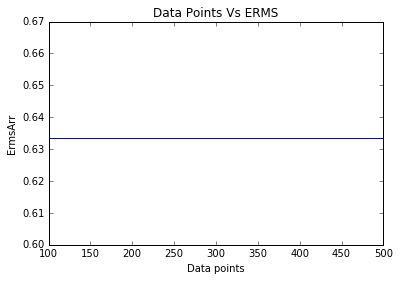

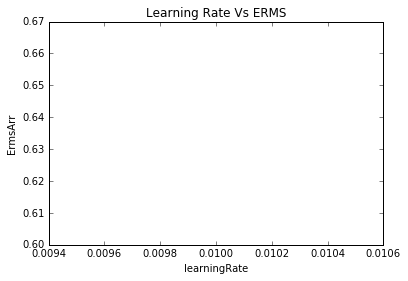

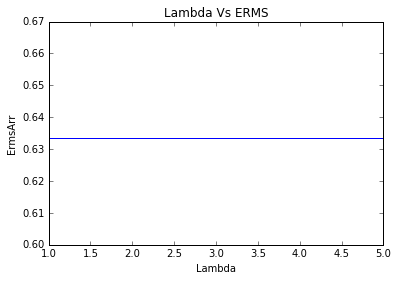

In [12]:
print (len(Erms_array))
print (len(learningRate_array))
print (len(Lambda_array))
print (len(Dataset))

plt.plot(Dataset, Erms_array)
# x axis values 
plt.xlabel('Data points') 
# naming the y axis 
plt.ylabel('ErmsArr') 

plt.title('Data Points Vs ERMS') 
plt.show()
##2nd
plt.plot(learningRate_array, Erms_array)
# x axis values 
plt.xlabel('learningRate') 
# naming the y axis 
plt.ylabel('ErmsArr') 

plt.title('Learning Rate Vs ERMS') 
plt.show()
##3rd
plt.plot(Lambda_array, Erms_array)
# x axis values 
plt.xlabel('Lambda') 
# naming the y axis 
plt.ylabel('ErmsArr') 

plt.title('Lambda Vs ERMS') 
plt.show()
